In [1]:
import os
import glob
import zipfile
import functools
import re

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import KFold
import matplotlib.image as mpimg
import pandas as pd
import imageio
from PIL import Image

In [2]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

# Preprocessing pipeline

In [3]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 100

In [4]:
def _process_pathnames(fname, label_path):
  """Load the image pair from given paths"""
  # We map this function onto each pathname pair  

  img_str = tf.read_file(fname)
  img = tf.image.decode_png(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  label_img = tf.image.decode_png(label_img_str, channels=1)
  return img, label_img

## Data augmentation

In [5]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  """This fn will perform the horizontal or vertical shift"""
  if width_shift_range or height_shift_range:
    if width_shift_range:
      width_shift_range = tf.random_uniform([], 
                                            -width_shift_range * img_shape[1],
                                            width_shift_range * img_shape[1])
    if height_shift_range:
      height_shift_range = tf.random_uniform([],
                                             -height_shift_range * img_shape[0],
                                             height_shift_range * img_shape[0])
    # Translate both 
    output_img = tfcontrib.image.translate(output_img,
                                           [width_shift_range, height_shift_range])
    label_img = tfcontrib.image.translate(label_img,
                                          [width_shift_range, height_shift_range])
  return output_img, label_img

In [6]:
def flip_img(horizontal_flip, tr_img, label_img):
  """Flip the image randomly"""
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [7]:
def rot90_img(rotate90, tr_img, label_img):
  """Rotating the image randomly in 90° angles"""
  if rotate90:
    rotate_count = tf.random_uniform([], 0, 4, dtype=tf.dtypes.int32)
    tr_img = tf.image.rot90(tr_img, rotate_count)
    label_img = tf.image.rot90(label_img, rotate_count)

  return tr_img, label_img

In [8]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             rotate90=False,  # Random number of 90° rotations
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize_images(label_img, resize)
    img = tf.image.resize_images(img, resize)

  if hue_delta:
    img = tf.image.random_hue(img, hue_delta)

  img, label_img = flip_img(horizontal_flip, img, label_img)
  img, label_img = rot90_img(rotate90, img, label_img)
  #img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
  label_img = tf.cast(label_img, tf.dtypes.float32) * scale
  img = tf.cast(img, tf.dtypes.float32) * scale 
  return img, label_img

In [9]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True,
                         repeat=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

  if shuffle:
    dataset = dataset.shuffle(num_x)

  # It's necessary to repeat our data for all epochs
  if repeat:
    dataset = dataset.repeat()

  dataset = dataset.batch(batch_size)
    
  return dataset

# Define data sets

In [10]:
img_dir = '../competition-data/training/images'
label_dir = '../competition-data/training/groundtruth'
test_dir = '../competition-data/test'

In [11]:
train_filenames = os.listdir(img_dir)
x_train_filenames = np.array([os.path.join(img_dir, filename) for filename in train_filenames])
y_train_filenames = np.array([os.path.join(label_dir, filename) for filename in train_filenames])
test_filenames = os.listdir(test_dir)
x_test_filenames = np.array([os.path.join(test_dir, filename) for filename in test_filenames])

print("Number of training examples: {}".format(len(x_train_filenames)))
print("Number of test examples: {}".format(len(x_test_filenames)))

kFold = KFold(n_splits=5, shuffle=True)

Number of training examples: 100
Number of test examples: 94


### Debug Output: Image paths

In [12]:
x_train_filenames[:5]

array(['../competition-data/training/images/satImage_045.png',
       '../competition-data/training/images/satImage_038.png',
       '../competition-data/training/images/satImage_054.png',
       '../competition-data/training/images/satImage_027.png',
       '../competition-data/training/images/satImage_008.png'],
      dtype='<U52')

In [13]:
y_train_filenames[:5]

array(['../competition-data/training/groundtruth/satImage_045.png',
       '../competition-data/training/groundtruth/satImage_038.png',
       '../competition-data/training/groundtruth/satImage_054.png',
       '../competition-data/training/groundtruth/satImage_027.png',
       '../competition-data/training/groundtruth/satImage_008.png'],
      dtype='<U57')

### Debug Output: x_train and y_train images

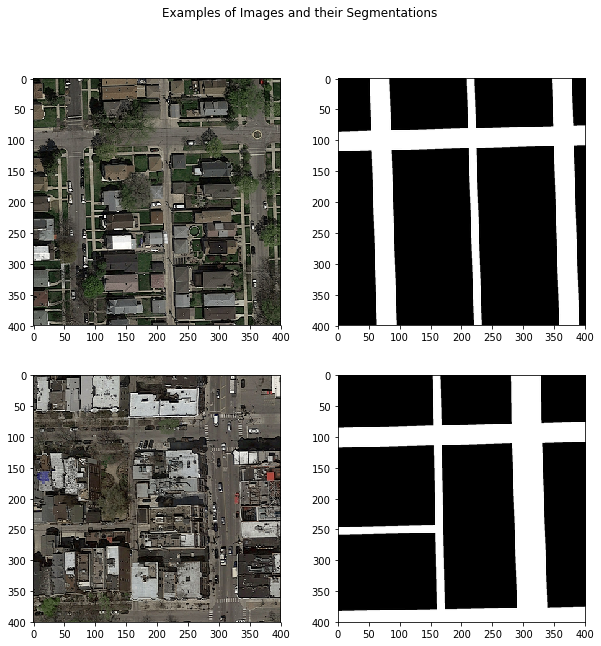

In [14]:
display_num = 2

r_choices = np.random.choice(len(x_train_filenames), display_num)
plt.figure(figsize=(10, 10))

for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]

  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname), cmap="gray")  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(mpimg.imread(y_pathname), cmap="gray")

plt.suptitle("Examples of Images and their Segmentations")
plt.show()

## Set up train and validation datasets
Note that we apply image augmentation to our training dataset but not our validation dataset. 

In [15]:
tr_cfg = {
  'resize': [img_shape[0], img_shape[1]],
  'scale': 1 / 255.,
  'horizontal_flip': True,
  'rotate90': True,
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [16]:
val_cfg = {
  'resize': [img_shape[0], img_shape[1]],
  'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

### Debug Output: Preprocessing pipeline

Instructions for updating:
Colocations handled automatically by placer.


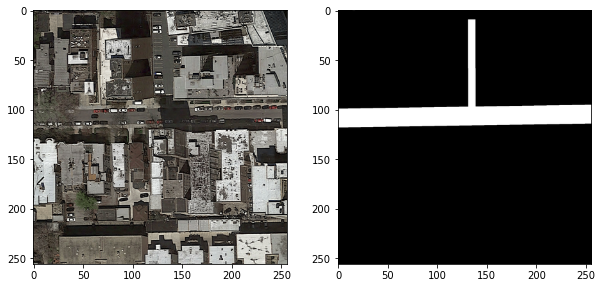

In [17]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  plt.imshow(label[0, :, :, 0], cmap='gray')
  plt.show()

## Define losses
Dice loss is a metric that measures overlap. More info on optimizing for Dice coefficient (our dice loss) can be found in the [paper](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf), where it was introduced. 

We use dice loss here because it performs better at class imbalanced problems by design. In addition, maximizing the dice coefficient and IoU metrics are the actual objectives and goals of our segmentation task. Using cross entropy is more of a proxy which is easier to maximize. Instead, we maximize our objective directly. 

In [18]:
def dice_coeff(y_true, y_pred):
  smooth = 1.
  # Flatten
  y_true_f = tf.reshape(y_true, [-1])
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  return score

In [19]:
def dice_loss(y_true, y_pred):
  loss = 1 - dice_coeff(y_true, y_pred)
  return loss

Here, we'll use a specialized loss function that combines binary cross entropy and our dice loss. This is based on [individuals who competed within this competition obtaining better results empirically](https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/40199). Try out your own custom losses to measure performance (e.g. bce + log(dice_loss), only bce, etc.)!

In [20]:
def binary_crossentropy(y_true, y_pred):
  return losses.binary_crossentropy(y_true, y_pred)

In [21]:
def root_mean_squared_error(y_true, y_pred):
  loss = tf.sqrt(losses.mean_squared_error(y_true, y_pred))
  return loss

In [22]:
def combined_loss(y_true, y_pred):
  loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
  return loss

# Define our neural network architecture

In [23]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def residual_block(input_tensor, num_filters):
  layer = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  layer = layers.BatchNormalization()(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Conv2D(num_filters, (3, 3), padding='same')(layer)
  layer = layers.BatchNormalization()(layer)
  layer = layers.Add()([input_tensor, layer])
  layer = layers.Activation('relu')(layer)
  return layer

def residual_bottleneck_block(input_tensor, num_filters):
  layer = layers.Conv2D(num_filters, (1, 1), padding='same')(input_tensor)
  layer = layers.BatchNormalization()(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Conv2D(num_filters, (3, 3), padding='same')(layer)
  layer = layers.BatchNormalization()(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Conv2D(num_filters, (1, 1), padding='same')(input_tensor)
  layer = layers.BatchNormalization()(layer)
  layer = layers.Add()([input_tensor, layer])
  layer = layers.Activation('relu')(layer)
  return layer

def encoder_block(input_tensor, num_filters, num_blocks=1):
  encoder = layers.Conv2D(num_filters, (1, 1), padding='same')(input_tensor)
  for i in range(num_blocks):
    encoder = residual_block(encoder, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  
  decoder = layers.Conv2D(num_filters, (1, 1), padding='same')(decoder)
  decoder = residual_block(decoder, num_filters)
  return decoder

In [24]:
def createModel():
  inputs = layers.Input(shape=img_shape)
  # 256
  encoder0_pool, encoder0 = encoder_block(inputs, 32, 2)
  # 128
  encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64, 2)
  # 64
  encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128, 2)
  # 32
  encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256, 2)
  # 16
  encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512, 2)
  # 8
  encoder5_pool, encoder5 = encoder_block(encoder4_pool, 1024, 2)
  # center
  decoder4 = decoder_block(encoder5, encoder4, 512)
  # 16
  decoder3 = decoder_block(decoder4, encoder3, 256)
  # 32
  decoder2 = decoder_block(decoder3, encoder2, 128)
  # 64
  decoder1 = decoder_block(decoder2, encoder1, 64)
  # 128
  decoder0 = decoder_block(decoder1, encoder0, 32)
  # 256
  outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
  return inputs, outputs

In [25]:
inputs, outputs = createModel()
model = models.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', 
            loss=root_mean_squared_error, 
            metrics=[binary_crossentropy, root_mean_squared_error, dice_loss])
model.summary()
model.save('model.hdf5')

del inputs, outputs, model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 128         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

# Train model

In [26]:
histories = []
cv = 0

for trainIndices, valIndices in kFold.split(x_train_filenames):
  cv = cv + 1
  save_model_path = 'weights_cv' + cv + 'epoch{epoch:03d}_rmse{val_root_mean_squared_error:.4f}.hdf5'
  train_ds = get_baseline_dataset(x_train_filenames[trainIndices], 
                                  y_train_filenames[trainIndices],
                                  preproc_fn=tr_preprocessing_fn,
                                  batch_size=batch_size)
  val_ds = get_baseline_dataset(x_train_filenames[valIndices], 
                                y_train_filenames[valIndices],
                                preproc_fn=val_preprocessing_fn,
                                batch_size=batch_size)
  
  tf.keras.backend.set_session(tf.Session())
  
  # Create model
  inputs, outputs = createModel()
  model = models.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', 
              loss=combined_loss, 
              metrics=[binary_crossentropy, root_mean_squared_error, dice_loss])
  cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_root_mean_squared_error', save_best_only=True, save_weights_only=True, verbose=1)
  es = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0.01, patience=15, verbose=1, mode='auto', restore_best_weights=True)
  
  history = model.fit(train_ds, 
                    steps_per_epoch=int(np.ceil(len(x_train_filenames[trainIndices]) / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(len(x_train_filenames[valIndices]) / float(batch_size))),
                    callbacks=[cp, es])
  histories.append(history)
  
  del inputs, outputs, model
  
  tf.keras.backend.get_session().close()

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
26/27 [===========================>..] - ETA: 0s - loss: 3.5003 - binary_crossentropy: 0.5145 - root_mean_squared_error: 0.3107 - dice_loss: 0.6523
Epoch 00001: val_root_mean_squared_error improved from inf to 0.45505, saving model to weights_epoch001_rmse0.4550.hdf5
27/27 [==============================] - 42s 2s/step - loss: 3.5006 - binary_crossentropy: 0.5113 - root_mean_squared_error: 0.3083 - dice_loss: 0.6556 - val_loss: 4.2110 - val_binary_crossentropy: 0.6698 - val_root_mean_squared_error: 0.4550 - val_dice_loss: 0.7339
Epoch 2/100
26/27 [===========================>..] - ETA: 0s - loss: 2.9379 - binary_crossentropy: 0.4136 - root_mean_squared_error: 0.2169 - dice_loss: 0.5657
Epoch 00002: val_root_mean_squared_error did not improve from 0.45505
27/27 [==============================] - 17s 615ms/step - loss: 2.9138 - binary_crossentropy: 0.4099 - root_mean_squared_error: 0.2153 - dice_loss: 0.5614 - val_loss: 41.4296 

Epoch 17/100
26/27 [===========================>..] - ETA: 0s - loss: 1.5302 - binary_crossentropy: 0.2287 - root_mean_squared_error: 0.0918 - dice_loss: 0.2813
Epoch 00017: val_root_mean_squared_error did not improve from 0.10687
27/27 [==============================] - 17s 619ms/step - loss: 1.5156 - binary_crossentropy: 0.2266 - root_mean_squared_error: 0.0907 - dice_loss: 0.2786 - val_loss: 2.6881 - val_binary_crossentropy: 0.5060 - val_root_mean_squared_error: 0.1834 - val_dice_loss: 0.3901
Epoch 18/100
26/27 [===========================>..] - ETA: 0s - loss: 1.6241 - binary_crossentropy: 0.2488 - root_mean_squared_error: 0.0955 - dice_loss: 0.2926
Epoch 00018: val_root_mean_squared_error improved from 0.10687 to 0.07597, saving model to weights_epoch018_rmse0.0760.hdf5
27/27 [==============================] - 17s 640ms/step - loss: 1.6143 - binary_crossentropy: 0.2476 - root_mean_squared_error: 0.0951 - dice_loss: 0.2905 - val_loss: 1.4366 - val_binary_crossentropy: 0.2185 - val_

Epoch 11/100
26/27 [===========================>..] - ETA: 0s - loss: 1.6987 - binary_crossentropy: 0.2496 - root_mean_squared_error: 0.1028 - dice_loss: 0.3167
Epoch 00011: val_root_mean_squared_error did not improve from 0.19761
27/27 [==============================] - 17s 622ms/step - loss: 1.7016 - binary_crossentropy: 0.2499 - root_mean_squared_error: 0.1029 - dice_loss: 0.3173 - val_loss: 4.2680 - val_binary_crossentropy: 0.9190 - val_root_mean_squared_error: 0.2801 - val_dice_loss: 0.5037
Epoch 12/100
26/27 [===========================>..] - ETA: 0s - loss: 1.6958 - binary_crossentropy: 0.2453 - root_mean_squared_error: 0.0998 - dice_loss: 0.3200
Epoch 00012: val_root_mean_squared_error improved from 0.19761 to 0.17558, saving model to weights_epoch012_rmse0.1756.hdf5
27/27 [==============================] - 17s 642ms/step - loss: 1.6775 - binary_crossentropy: 0.2423 - root_mean_squared_error: 0.0987 - dice_loss: 0.3169 - val_loss: 2.5207 - val_binary_crossentropy: 0.4340 - val_

Epoch 27/100
26/27 [===========================>..] - ETA: 0s - loss: 1.2653 - binary_crossentropy: 0.1889 - root_mean_squared_error: 0.0692 - dice_loss: 0.2329
Epoch 00027: val_root_mean_squared_error did not improve from 0.08085
27/27 [==============================] - 17s 622ms/step - loss: 1.2534 - binary_crossentropy: 0.1877 - root_mean_squared_error: 0.0684 - dice_loss: 0.2301 - val_loss: 2.6923 - val_binary_crossentropy: 0.4562 - val_root_mean_squared_error: 0.1288 - val_dice_loss: 0.4413
Epoch 28/100
26/27 [===========================>..] - ETA: 0s - loss: 1.2291 - binary_crossentropy: 0.1851 - root_mean_squared_error: 0.0660 - dice_loss: 0.2246
Epoch 00028: val_root_mean_squared_error did not improve from 0.08085
27/27 [==============================] - 17s 625ms/step - loss: 1.2425 - binary_crossentropy: 0.1860 - root_mean_squared_error: 0.0668 - dice_loss: 0.2281 - val_loss: 1.9899 - val_binary_crossentropy: 0.3473 - val_root_mean_squared_error: 0.1025 - val_dice_loss: 0.316

Epoch 23/100
26/27 [===========================>..] - ETA: 0s - loss: 1.4070 - binary_crossentropy: 0.2083 - root_mean_squared_error: 0.0795 - dice_loss: 0.2606
Epoch 00023: val_root_mean_squared_error did not improve from 0.08909
27/27 [==============================] - 17s 621ms/step - loss: 1.4056 - binary_crossentropy: 0.2083 - root_mean_squared_error: 0.0795 - dice_loss: 0.2602 - val_loss: 6.7401 - val_binary_crossentropy: 1.2601 - val_root_mean_squared_error: 0.1825 - val_dice_loss: 0.9867
Epoch 24/100
26/27 [===========================>..] - ETA: 0s - loss: 1.3060 - binary_crossentropy: 0.1976 - root_mean_squared_error: 0.0715 - dice_loss: 0.2378
Epoch 00024: val_root_mean_squared_error did not improve from 0.08909
27/27 [==============================] - 17s 623ms/step - loss: 1.3010 - binary_crossentropy: 0.1971 - root_mean_squared_error: 0.0711 - dice_loss: 0.2366 - val_loss: 4.2668 - val_binary_crossentropy: 0.7191 - val_root_mean_squared_error: 0.1588 - val_dice_loss: 0.703

Epoch 5/100
26/27 [===========================>..] - ETA: 0s - loss: 2.6827 - binary_crossentropy: 0.3849 - root_mean_squared_error: 0.1913 - dice_loss: 0.5094
Epoch 00005: val_root_mean_squared_error did not improve from 0.76187
27/27 [==============================] - 17s 622ms/step - loss: 2.6950 - binary_crossentropy: 0.3879 - root_mean_squared_error: 0.1919 - dice_loss: 0.5104 - val_loss: 20.8205 - val_binary_crossentropy: 6.2685 - val_root_mean_squared_error: 0.7806 - val_dice_loss: 0.6717
Epoch 6/100
26/27 [===========================>..] - ETA: 0s - loss: 2.4355 - binary_crossentropy: 0.3472 - root_mean_squared_error: 0.1712 - dice_loss: 0.4646
Epoch 00006: val_root_mean_squared_error did not improve from 0.76187
27/27 [==============================] - 17s 623ms/step - loss: 2.4542 - binary_crossentropy: 0.3533 - root_mean_squared_error: 0.1730 - dice_loss: 0.4647 - val_loss: 21.0797 - val_binary_crossentropy: 6.3287 - val_root_mean_squared_error: 0.7932 - val_dice_loss: 0.697

27/27 [==============================] - 18s 666ms/step - loss: 1.4968 - binary_crossentropy: 0.2257 - root_mean_squared_error: 0.0882 - dice_loss: 0.2732 - val_loss: 1.7945 - val_binary_crossentropy: 0.2826 - val_root_mean_squared_error: 0.0919 - val_dice_loss: 0.3156
Epoch 21/100
26/27 [===========================>..] - ETA: 0s - loss: 1.5618 - binary_crossentropy: 0.2363 - root_mean_squared_error: 0.0911 - dice_loss: 0.2843
Epoch 00021: val_root_mean_squared_error did not improve from 0.09194
27/27 [==============================] - 17s 625ms/step - loss: 1.5403 - binary_crossentropy: 0.2318 - root_mean_squared_error: 0.0895 - dice_loss: 0.2816 - val_loss: 1.9008 - val_binary_crossentropy: 0.2918 - val_root_mean_squared_error: 0.1006 - val_dice_loss: 0.3418
Epoch 22/100
26/27 [===========================>..] - ETA: 0s - loss: 1.5573 - binary_crossentropy: 0.2334 - root_mean_squared_error: 0.0921 - dice_loss: 0.2857
Epoch 00022: val_root_mean_squared_error did not improve from 0.0919

Epoch 37/100
26/27 [===========================>..] - ETA: 0s - loss: 1.3745 - binary_crossentropy: 0.2067 - root_mean_squared_error: 0.0765 - dice_loss: 0.2515
Epoch 00037: val_root_mean_squared_error did not improve from 0.07763
27/27 [==============================] - 17s 623ms/step - loss: 1.3677 - binary_crossentropy: 0.2052 - root_mean_squared_error: 0.0761 - dice_loss: 0.2507 - val_loss: 3.8832 - val_binary_crossentropy: 0.6286 - val_root_mean_squared_error: 0.1433 - val_dice_loss: 0.6658
Epoch 38/100
26/27 [===========================>..] - ETA: 0s - loss: 1.2961 - binary_crossentropy: 0.2031 - root_mean_squared_error: 0.0730 - dice_loss: 0.2289
Epoch 00038: val_root_mean_squared_error did not improve from 0.07763
27/27 [==============================] - 17s 628ms/step - loss: 1.2822 - binary_crossentropy: 0.2007 - root_mean_squared_error: 0.0721 - dice_loss: 0.2267 - val_loss: 2.4992 - val_binary_crossentropy: 0.4087 - val_root_mean_squared_error: 0.1140 - val_dice_loss: 0.424

Epoch 12/100
26/27 [===========================>..] - ETA: 0s - loss: 1.4927 - binary_crossentropy: 0.2253 - root_mean_squared_error: 0.0885 - dice_loss: 0.2722
Epoch 00012: val_root_mean_squared_error did not improve from 0.14723
27/27 [==============================] - 17s 625ms/step - loss: 1.4834 - binary_crossentropy: 0.2242 - root_mean_squared_error: 0.0880 - dice_loss: 0.2703 - val_loss: 4.1714 - val_binary_crossentropy: 0.7378 - val_root_mean_squared_error: 0.1538 - val_dice_loss: 0.6527
Epoch 13/100
26/27 [===========================>..] - ETA: 0s - loss: 1.5760 - binary_crossentropy: 0.2401 - root_mean_squared_error: 0.0908 - dice_loss: 0.2853
Epoch 00013: val_root_mean_squared_error improved from 0.14723 to 0.12959, saving model to weights_epoch013_rmse0.1296.hdf5
27/27 [==============================] - 18s 665ms/step - loss: 1.5594 - binary_crossentropy: 0.2372 - root_mean_squared_error: 0.0898 - dice_loss: 0.2826 - val_loss: 2.0759 - val_binary_crossentropy: 0.3676 - val_

Epoch 28/100
26/27 [===========================>..] - ETA: 0s - loss: 1.2686 - binary_crossentropy: 0.1935 - root_mean_squared_error: 0.0702 - dice_loss: 0.2294
Epoch 00028: val_root_mean_squared_error did not improve from 0.09015
27/27 [==============================] - 17s 629ms/step - loss: 1.2589 - binary_crossentropy: 0.1923 - root_mean_squared_error: 0.0696 - dice_loss: 0.2273 - val_loss: 4.4681 - val_binary_crossentropy: 0.7236 - val_root_mean_squared_error: 0.1723 - val_dice_loss: 0.7657
Epoch 29/100
26/27 [===========================>..] - ETA: 0s - loss: 1.2301 - binary_crossentropy: 0.1898 - root_mean_squared_error: 0.0657 - dice_loss: 0.2203
Epoch 00029: val_root_mean_squared_error improved from 0.09015 to 0.05536, saving model to weights_epoch029_rmse0.0554.hdf5
27/27 [==============================] - 18s 671ms/step - loss: 1.2242 - binary_crossentropy: 0.1889 - root_mean_squared_error: 0.0654 - dice_loss: 0.2192 - val_loss: 1.0819 - val_binary_crossentropy: 0.1596 - val_

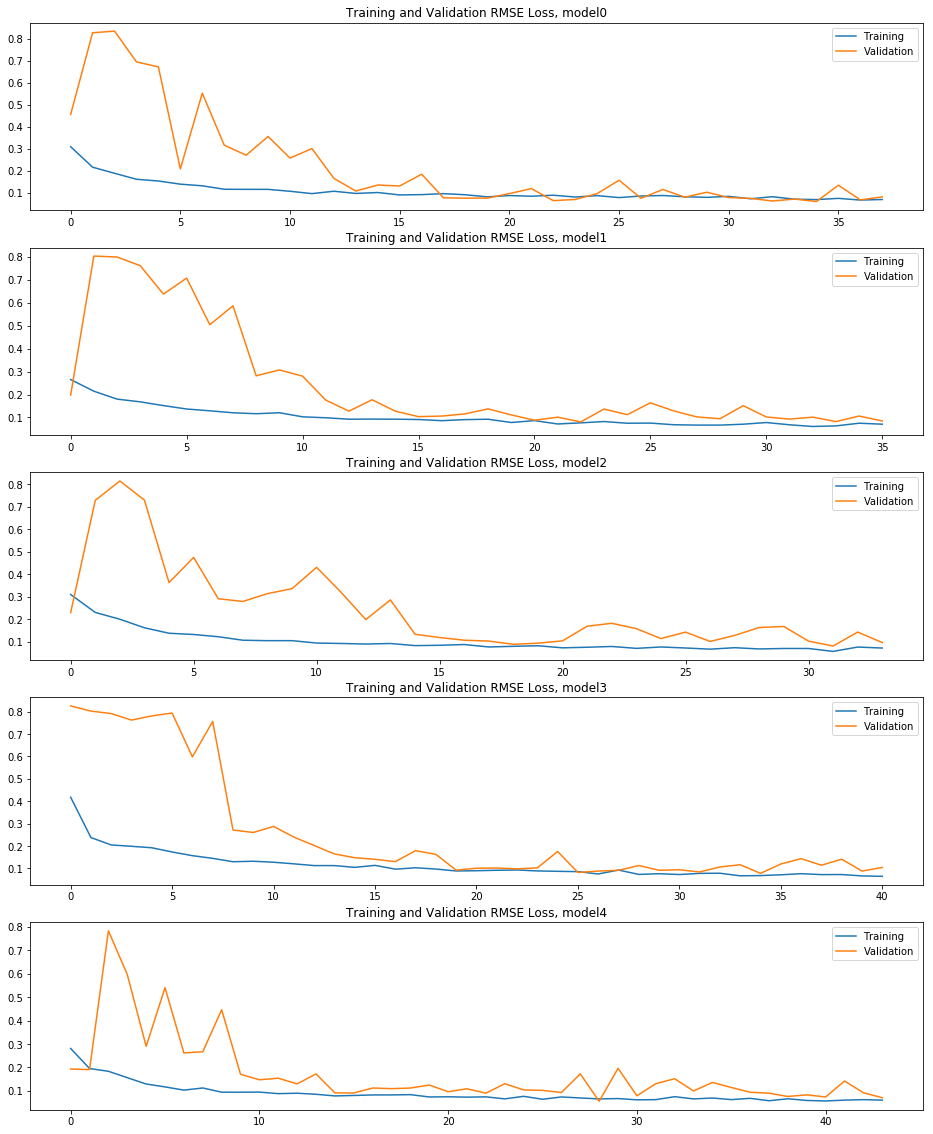

In [42]:
n = len(histories)

plt.figure(figsize=(16, 20))
for i in range(n):
  loss = histories[i].history['root_mean_squared_error']
  val_loss = histories[i].history['val_root_mean_squared_error']
  epochs_range = range(len(loss))

  plt.subplot(n, 1, i+1)
  plt.plot(epochs_range, loss, label='Training')
  plt.plot(epochs_range, val_loss, label='Validation')
  plt.legend(loc='upper right')
  plt.title('Training and Validation RMSE Loss, model' + str(i))

plt.savefig('loss_graph.png')
plt.show()

# Qualitative evaluation of our performance 

In [44]:
# Load weights from latest checkpoint
weights_path = sorted(glob.glob('weights*'), reverse=True)[0]
# Alternatively, set weight file directly
#weights_path = "weights_XY.hdf5"

tf.keras.backend.set_session(tf.Session())
model = models.load_model('model.hdf5', custom_objects={'dice_loss': dice_loss,
                                                      'root_mean_squared_error': root_mean_squared_error,
                                                      'binary_crossentropy': binary_crossentropy})
# Alternatively, load the weights directly: 
model.load_weights(weights_path)
print("Loaded model weights from:", weights_path)

Loaded model weights from: weights_epoch035_rmse0.0776.hdf5


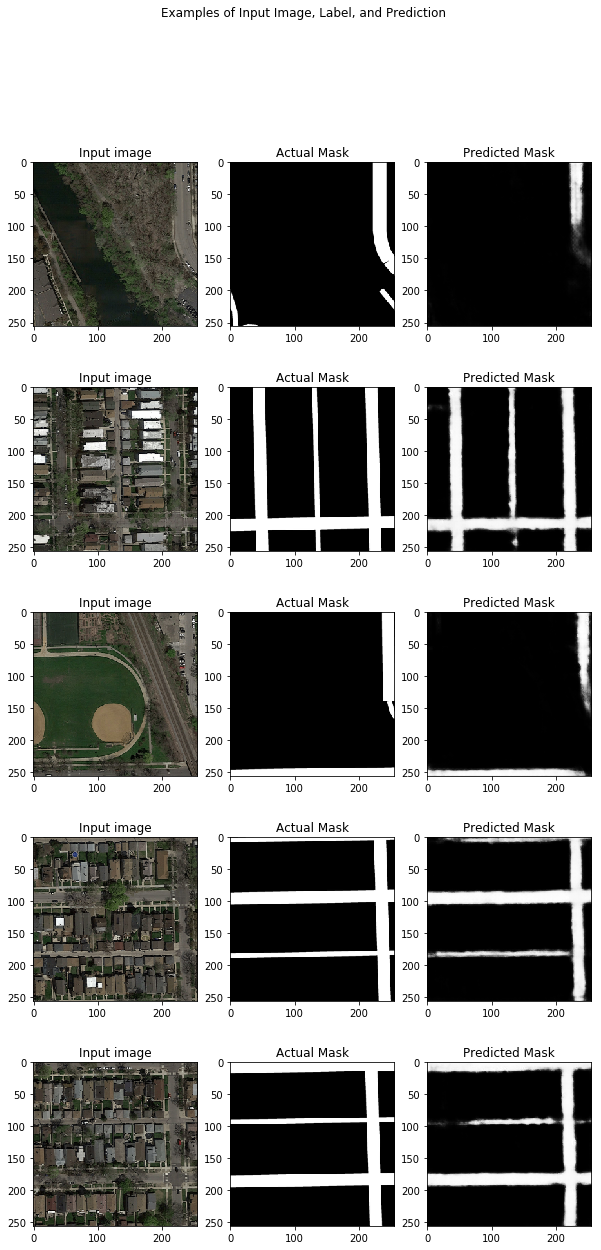

In [45]:
# Visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  predicted_label = model.predict(batch_of_imgs)[0]

  plt.subplot(5, 3, 3 * i + 1)
  plt.imshow(img)
  plt.title("Input image")
  
  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label[0, :, :, 0], cmap='gray')
  plt.title("Actual Mask")
  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label[:, :, 0], cmap='gray')
  plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

# Create test set predictions

In [ ]:
# create directory for predictions
prediction_dir = weights_path.replace("weights", "predictions", 1).replace(".hdf5", "", 1)
os.mkdir(prediction_dir)

test_ds = get_baseline_dataset(x_test_filenames,
                               x_test_filenames, 
                               preproc_fn=val_preprocessing_fn,
                               batch_size=batch_size,
                               shuffle=False,
                               repeat=False)

data_aug_iter = test_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
count=0

sess = tf.keras.backend.get_session()
try:
  while True:
    batch_of_imgs, label = sess.run(next_element)
    predicted_labels = model.predict(batch_of_imgs)
    
    # rescale images from [0, 1] to [0, 255]
    predicted_labels = predicted_labels / val_cfg['scale']

    for i in range(len(predicted_labels)):
      pred = Image.fromarray(predicted_labels[i, :, :, 0], 'F').resize((608, 608)).convert('L')
      imageio.imwrite(os.path.join(prediction_dir, test_filenames[count]), pred)
      count += 1

except tf.errors.OutOfRangeError:
  pass

In [ ]:
# Show some of the predictions
display_num = 4

r_choices = np.random.choice(len(test_filenames), display_num)
plt.figure(figsize=(10, 20))

for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_test_filenames[img_num]
  y_pathname = os.path.join(prediction_dir, test_filenames[img_num])

  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname), cmap="gray")  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(mpimg.imread(y_pathname), cmap="gray")

plt.suptitle("Examples of images and their predicted segmentations")
plt.show()

### Mask to submission

In [ ]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
  df = np.mean(patch)
  if df > foreground_threshold:
    return 1
  else:
    return 0


def mask_to_submission_strings(image_filename):
  """Reads a single image and outputs the strings that should go into the submission file"""
  img_number = int(re.search(r"\d+(?=\.png$)", image_filename).group(0))
  im = mpimg.imread(image_filename)
  patch_size = 16
  for j in range(0, im.shape[1], patch_size):
    for i in range(0, im.shape[0], patch_size):
      patch = im[i:i + patch_size, j:j + patch_size]
      label = patch_to_label(patch)
      yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
  """Converts images into a submission file"""
  with open(submission_filename, 'w') as f:
    f.write('id,prediction\n')
    for fn in image_filenames[0:]:
      f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))

In [ ]:
submission_filename = weights_path.replace("weights", "submission", 1).replace(".hdf5", ".csv", 1)
image_filenames = [os.path.join(prediction_dir, filename) for filename in os.listdir(prediction_dir)]
masks_to_submission(submission_filename, *image_filenames)

In [ ]:
print("Validating submission file:", submission_filename)
df = pd.read_csv(submission_filename)

print('Shape of csv:', df.shape)
assert df.shape == (135736, 2), "Invalid number of rows or columns in submission file!"
assert df['id'].unique().size == 135736, "Column 'id' should contain 135736 unique values!"

meanPred = df['prediction'].mean()
print("Mean prediction: {:.3f}".format(meanPred))
assert meanPred > 0.05 and meanPred < 0.3, "Very unlikely mean prediction!"

print("Submission file looks OKAY!")